In [3]:
from google.colab import drive 

drive.mount('/gdrive') # 구글드라이브 연결

Mounted at /gdrive


In [4]:
import zipfile as zf
files = zf.ZipFile("/gdrive/My Drive/Colab Notebooks/onlyimagedata.zip",'r') # 압축 파일의 자료 읽기
files.extractall()
files.close()

In [5]:
# 폴더명 기준으로 라벨 구분
import os

labels = os.listdir(r'/content/data') 
print('라벨:', labels)

라벨: ['pet', 'vin', 'paper', 'plastic', 'styro', 'can']


In [6]:
# 각 라벨마다 train, val 파일 생성 및 데이터 나누기(8대2)
!pip install split-folders

import splitfolders

os.mkdir("/content/data_new")
splitfolders.ratio('/content/data', output="/content/data_new", seed=77, ratio=(0.8, 0.2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 60000 files [00:09, 6413.99 files/s]


In [7]:
!pip install torch
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy
import numpy as np
import time

cudnn.benchmark = True # 최적의 backend 연산을 찾는 flag를 true 로 설정
plt.ion()   # 대화형 모드

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용가능 여부 확인. cuda가 설정되어 있으면 연산을 gpu로 하고, 아니면 cpu
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


device(type='cuda', index=0)

In [8]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체를 train, val 별로 지정
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),# 이미지 resize 
        transforms.RandomResizedCrop(224), # 이미지를 랜덤으로 자르기
        transforms.RandomHorizontalFlip(),# 데이터 증진(augmentation)
        transforms.ToTensor(), # 데이터를 tensor로 바꿔준다. 넘파이는 정수값이 들어있어 오차율 가늠이 힘들고 CIDA 연산도 지원하지 않음
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화(normalization)작업에 쓰일 각 채널의 표준값과 표준편차값, PyTorch 기본값으로 셋팅
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = '/content/data_new' # 이미지 데이터셋에 상단의 transform 내용 적용

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# train과 valid 데이터 개수 확인
print(len(image_datasets['train']), len(image_datasets['val']))

48000 12000


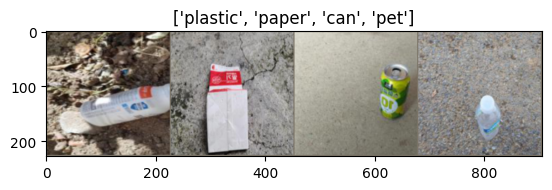

In [11]:
import matplotlib.pyplot as plt # 데이터 시각화

def imshow(inp, title=None):
    # torch.Tensor를 numpy 객체로 변환
    inp = inp.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # 이미지 출력
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes]) #  batch size만큼의 image, label이 출력

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25): # 모델학습 함수
    since = time.time()

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):  # 에폭마다 for문을 넣어주고
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습단계와 테스트 단계를 거쳐서 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # 아웃풋 설정
                    _, preds = torch.max(outputs, 1) # 인풋에 대현 예측값
                    loss = criterion(outputs, labels) # 예측값과 실제 결과값 비교

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward() # 역전파
                        optimizer.step() # 최적화(optimizer 스텝 증가) 

                # 통계
                running_loss += loss.item() * inputs.size(0) # 교차엔트로피 계산. deafualt값이 mean이므로 각 데이터 마다의 손실 평균이 저장, 배치 사이즈를 곱해줘 한 배치 사이즈의 loss 총합을 계산
                running_corrects += torch.sum(preds == labels.data) # 예측값이 맞은 횟수 더하기
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase] # 에폭에 따른 loss, accuracy 계산 (전체 데이터 loss합/ 각 데이터셋 크기)
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 

            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}') # loss, accuracy 출력

            if phase == 'train':
                loss_history['train'].append(epoch_loss)
                metric_history['train'].append(epoch_acc)
            else:
                loss_history['val'].append(epoch_loss)
                metric_history['val'].append(epoch_acc)

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc: # best_acc, weight 값 저장
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since       # 반복할 때마다 현재 - 기존 시간 계산해 걸린 시간 표시
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Accuracy: {best_acc:4f}')

    # 제일 잘 나온 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [13]:
def visualize_model(model, num_images=6): # 시각화 함수
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # 모델에 나온 값
            _, preds = torch.max(outputs, 1) # 예측값

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}') #예측값만 출력
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training) # 앞에서 선언한 값에 넣기
                    return
        model.train(mode=was_training)

In [14]:
from torch.optim import lr_scheduler # 미세조정 (무작위 초기화가 아닌, 미리 학습한 신경망으로 초기화한다)

model_ft = models.resnet50(pretrained=True) # False가 되면 모델의 구조만 가져오고 초깃값은 랜덤 설정
num_ftrs = model_ft.fc.in_features  # fc는 모델의 마지막 layer를, in_features는 해당 층의 입력 채널 수 반환

# 여기서 각 출력 샘플의 크기를를 nn.Linear(num_ftrs, len (class_names))로 일반화
model_ft.fc = nn.Linear(num_ftrs, len (class_names)) # 512, 6(라벨 수에 맞춰야 함함)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 곱해서 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [15]:
from torchsummary import summary

summary(model_ft, (3,32,32)) # 모델 정보 확인

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [16]:
model_ft, loss_hist, metric_hist = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10) 

Epoch 0/9
----------
train Loss: 0.6900 Accuracy: 0.7550
val Loss: 0.3839 Accuracy: 0.8610

Epoch 1/9
----------
train Loss: 0.4576 Accuracy: 0.8375
val Loss: 0.2909 Accuracy: 0.9044

Epoch 2/9
----------
train Loss: 0.4008 Accuracy: 0.8564
val Loss: 0.2822 Accuracy: 0.8997

Epoch 3/9
----------
train Loss: 0.3661 Accuracy: 0.8691
val Loss: 0.2751 Accuracy: 0.9069

Epoch 4/9
----------
train Loss: 0.3398 Accuracy: 0.8771
val Loss: 0.2329 Accuracy: 0.9209

Epoch 5/9
----------
train Loss: 0.3247 Accuracy: 0.8828
val Loss: 0.2485 Accuracy: 0.9112

Epoch 6/9
----------
train Loss: 0.3055 Accuracy: 0.8918
val Loss: 0.2515 Accuracy: 0.9110

Epoch 7/9
----------
train Loss: 0.2213 Accuracy: 0.9198
val Loss: 0.1746 Accuracy: 0.9426

Epoch 8/9
----------
train Loss: 0.1987 Accuracy: 0.9280
val Loss: 0.1735 Accuracy: 0.9426

Epoch 9/9
----------
train Loss: 0.1880 Accuracy: 0.9323
val Loss: 0.1601 Accuracy: 0.9464

Training complete in 135m 12s
Best val Accuracy: 0.946417


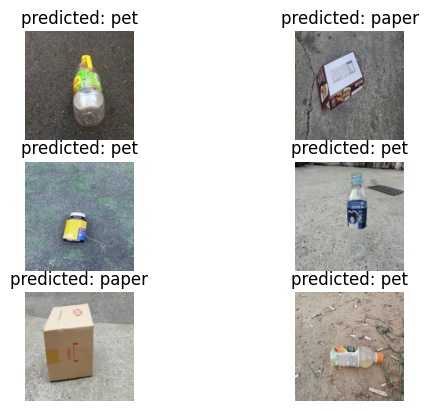

In [17]:
visualize_model(model_ft) # 예측값 시각화 

In [19]:
model_path = os.path.join('/content/data_new', str('model_resnet50_fine')+".pth") # 모델저장
torch.save(model_ft.state_dict(), model_path)

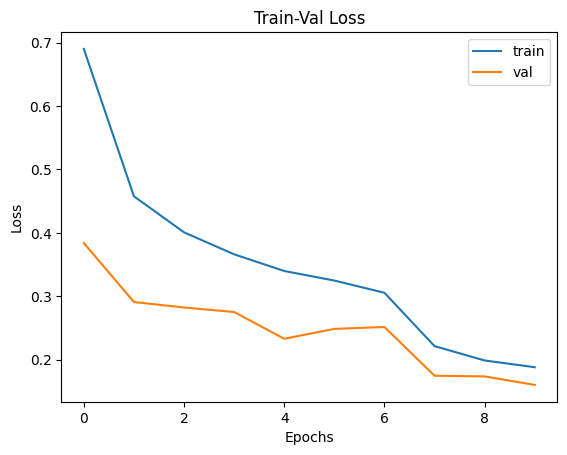

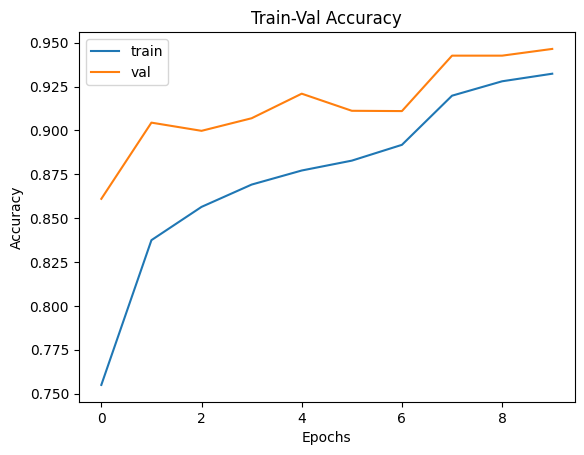

In [21]:

train_loss_history = loss_hist["train"] # 그래프로 표시
val_loss_history = loss_hist["val"]
train_acc_history = metric_hist["train"]
val_acc_history = metric_hist["val"]

train_acc_history = torch.stack(train_acc_history).cpu() # 리스트가 파이토치 텐서라 1차원 텐서로 바꿔주고 gpu 텐서는 넘파이 변환이 안되므로 cpu로..
val_acc_history =  torch.stack(val_acc_history).cpu()

plt.title("Train-Val Loss")
plt.plot(train_loss_history,label="train")
plt.plot(val_loss_history,label="val")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(train_acc_history,label="train")
plt.plot(val_acc_history,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

마지막의 완전히 연결 된 계층을 제외한 모든 신경망의 가중치를 고정. 
마지막 계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습한다.

In [22]:
model_conv = torchvision.models.resnet50(pretrained=True) # 미세 조정, 마지막 계층을 제외한 신경망을 고정 후 다시 돌려보기
for param in model_conv.parameters():
    param.requires_grad = False # 매개변수 고정 후 경사도 계산 안하기(requires_grad 기본값은 True 이다다)

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len (class_names)) # 512, 6

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이번에는 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [23]:
model_conv, loss_hist, metric_hist = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10) #경사도 계산을 거의 안해도 되므로 시간이 거의 절반으로 줄어든다..그래도 순전파 계산은 해야함

Epoch 0/9
----------
train Loss: 1.0341 Accuracy: 0.6355
val Loss: 0.5674 Accuracy: 0.8078

Epoch 1/9
----------
train Loss: 0.9776 Accuracy: 0.6648
val Loss: 0.5449 Accuracy: 0.8116

Epoch 2/9
----------
train Loss: 0.9446 Accuracy: 0.6751
val Loss: 0.5627 Accuracy: 0.8127

Epoch 3/9
----------
train Loss: 0.9242 Accuracy: 0.6801
val Loss: 0.5581 Accuracy: 0.8099

Epoch 4/9
----------
train Loss: 0.9119 Accuracy: 0.6837
val Loss: 0.7203 Accuracy: 0.7635

Epoch 5/9
----------
train Loss: 0.8888 Accuracy: 0.6900
val Loss: 0.5269 Accuracy: 0.8199

Epoch 6/9
----------
train Loss: 0.8892 Accuracy: 0.6940
val Loss: 0.5947 Accuracy: 0.8051

Epoch 7/9
----------
train Loss: 0.7493 Accuracy: 0.7331
val Loss: 0.4967 Accuracy: 0.8274

Epoch 8/9
----------
train Loss: 0.7315 Accuracy: 0.7396
val Loss: 0.4615 Accuracy: 0.8391

Epoch 9/9
----------
train Loss: 0.7330 Accuracy: 0.7396
val Loss: 0.5428 Accuracy: 0.8133

Training complete in 65m 34s
Best val Accuracy: 0.839083


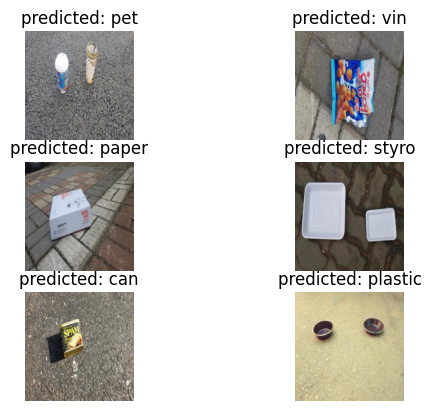

In [24]:
visualize_model(model_conv) # 새 예측값 시각화 

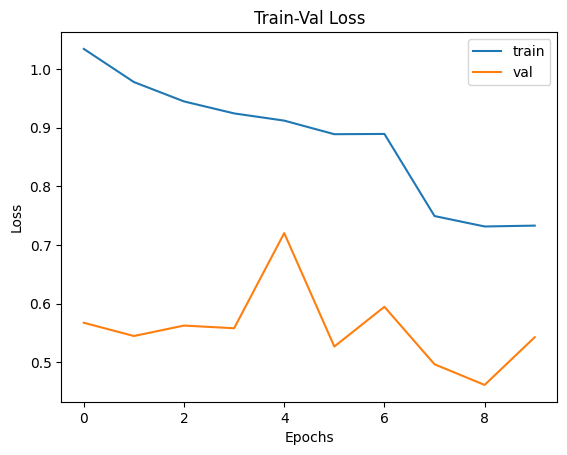

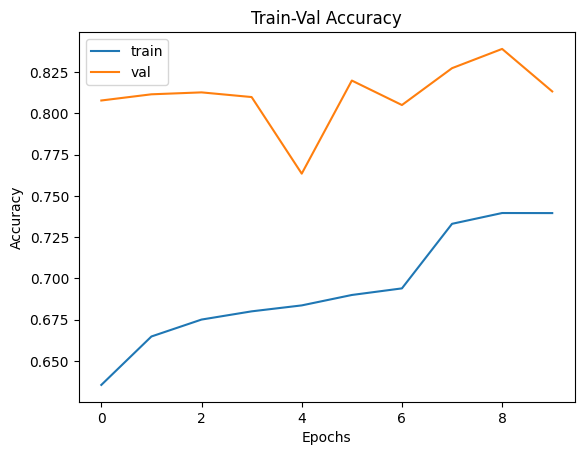

In [25]:

train_loss_history = loss_hist["train"] # 그래프로 표시
val_loss_history = loss_hist["val"]
train_acc_history = metric_hist["train"]
val_acc_history = metric_hist["val"]

train_acc_history = torch.stack(train_acc_history).cpu() # 리스트가 파이토치 텐서라 1차원 텐서로 바꿔주고 gpu 텐서는 넘파이 변환이 안되므로 cpu로..
val_acc_history =  torch.stack(val_acc_history).cpu()

plt.title("Train-Val Loss")
plt.plot(train_loss_history,label="train")
plt.plot(val_loss_history,label="val")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(train_acc_history,label="train")
plt.plot(val_acc_history,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [26]:
model_path = os.path.join('/content/data_new', str('model_resnet50')+".pth") # 모델저장
torch.save(model_conv.state_dict(), model_path)